In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import math
%matplotlib inline

This is a kaggle competition project done for my machine learning class that estimates the air quality index for Jing'an temple in Shanghai

In [73]:
df = pd.read_csv('''./Data/ShanghaiPMI25_tr.csv''')
df2 = pd.read_csv('''./Data/ShanghaiPMI25_te.csv''')

In [74]:
df.head()

,No,year,month,day,hour,season,PM_Jingan,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,26305,2013,1,1,0,4,66,-5,69.00,1023,0,SW,60,0.0,0.0
1,26306,2013,1,1,1,4,67,-5,69.00,1023,0,SW,62,0.0,0.0
2,26308,2013,1,1,3,4,73,-4,74.41,1023,0,SW,65,0.0,0.0
3,26309,2013,1,1,4,4,75,-4,80.04,1023,-1,SW,68,0.0,0.0
4,26310,2013,1,1,5,4,73,-4,80.04,1023,-1,SW,70,0.0,0.0


First we convert combined wind direction to a format which our model can parse. We turn the cbwd column onto four columns with a binary value for each direction i.e N, S, E, W. There is a posible colinearity trap here because if any three directions are 0 we know that the fourth one will be a 1. Or if two diretions have 1 values then the rest will we know have to be zeroes.However because the wind direction can either be 2 directions or a singular direction if we have one positive value and two zero values we are unable to determine the fourth value because it could either be a 1 or a zero.

In [75]:
df['N'] = pd.Series([1 if 'N' in x else 0 for x in df['cbwd']], index=df.index)
df['S'] = pd.Series([1 if 'S' in x else 0 for x in df['cbwd']], index=df.index)
df['E'] = pd.Series([1 if 'E' in x else 0 for x in df['cbwd']], index=df.index)
df['W'] = pd.Series([1 if 'W' in x else 0 for x in df['cbwd']], index=df.index)
df['year'] = df['year'] - 2013
df.head()
df2['N'] = pd.Series([1 if 'N' in x else 0 for x in df2['cbwd']], index=df2.index)
df2['S'] = pd.Series([1 if 'S' in x else 0 for x in df2['cbwd']], index=df2.index)
df2['E'] = pd.Series([1 if 'E' in x else 0 for x in df2['cbwd']], index=df2.index)
df2['W'] = pd.Series([1 if 'W' in x else 0 for x in df2['cbwd']], index=df2.index)
df2['year'] = df2['year'] - 2013
df2.head()

,No,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,N,S,E,W
0,41333,1,9,19,4,3,16,77.79,1013,20,cv,0,0.0,0.0,0,0,0,0
1,41335,1,9,19,6,3,18,93.94,1013,19,NW,5,0.3,0.3,1,0,0,1
2,41336,1,9,19,7,3,17,88.20,1014,19,NE,3,2.2,2.5,1,0,1,0
3,41337,1,9,19,8,3,18,93.94,1014,19,NE,7,1.5,4.0,1,0,1,0
4,41338,1,9,19,9,3,18,93.94,1014,19,NE,9,1.2,5.2,1,0,1,0


Next we drop the cbwd column that we replaced and convert the database float64 data objects to avoid runtime warnings


In [76]:
df = df.drop(columns=['cbwd'])
df2 = df2.drop(columns=['cbwd'])
df = df.astype('float64')
df2 = df2.astype('float64')
df.head()

,No,year,month,day,hour,season,PM_Jingan,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,N,S,E,W
0,26305.0,0.0,1.0,1.0,0.0,4.0,66.0,-5.0,69.00,1023.0,0.0,60.0,0.0,0.0,0.0,1.0,0.0,1.0
1,26306.0,0.0,1.0,1.0,1.0,4.0,67.0,-5.0,69.00,1023.0,0.0,62.0,0.0,0.0,0.0,1.0,0.0,1.0
2,26308.0,0.0,1.0,1.0,3.0,4.0,73.0,-4.0,74.41,1023.0,0.0,65.0,0.0,0.0,0.0,1.0,0.0,1.0
3,26309.0,0.0,1.0,1.0,4.0,4.0,75.0,-4.0,80.04,1023.0,-1.0,68.0,0.0,0.0,0.0,1.0,0.0,1.0
4,26310.0,0.0,1.0,1.0,5.0,4.0,73.0,-4.0,80.04,1023.0,-1.0,70.0,0.0,0.0,0.0,1.0,0.0,1.0


Next we create our X_train, y_train, and X_test dataframes and test to make sure that they are the right size.

In [77]:
X_train = df[['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation', 'Iprec', 'N', 'S', 'E', 'W']]

y_train = np.array([x for x in df.PM_Jingan])
X_test = df2.drop('No', axis=1)

assert X_train.shape[0] == y_train.shape[0]
assert X_train.shape[1] == X_test.shape[1]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)


(13164, 16)
(13164,)
(9523, 16)


Here we have our first look at the distribution of our y values and it is clearly very skewed


Text(0.5, 1.0, 'Un-Normalized')

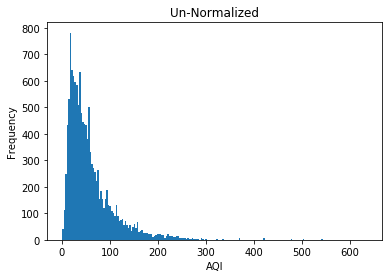

In [78]:
plt.hist(y_train, bins=200)
plt.ylabel('Frequency')
plt.xlabel('AQI');
plt.title('Un-Normalized')

We then feed our data into a pipeline of a standard scaler and a liner regression model. We do 10 fold cross validation using mse as our metric and then plot our predicted vs measured values (using predicted as the x and measured as the y for proper analysis more reading here: https://www.researchgate.net/publication/230692926_How_to_Evaluate_Models_Observed_vs_Predicted_or_Predicted_vs_Observed) and our residual vs predicted values. Ideally we want a low absolute value for our mse and for our data in a graphs to be close to and evenly distrubted across the plotted lines. Our cross validation returns an avg of mse of over 3000 indicating a very poor model, and our graphs confirm this. For our predicted vs measured plot our data is grouped up and very far from the line and many of the estimates are negative even though aqi cannot have values less than 0. For the residual plot we have many more negative residuals than positive ones and many of the negative ones are extremely large.

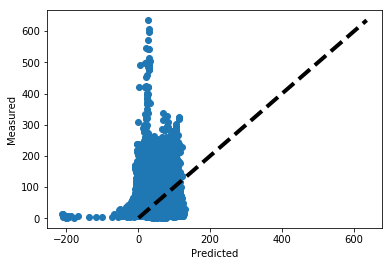

[ -3315.48743613  -1301.81699129  -1391.25335324  -1379.40410648
  -2131.80241988 -16318.44265403  -3674.40863246  -1120.97130893
  -1317.99586182   -809.51488621]
-3276.1097650477923


In [79]:
pipeline = Pipeline([
    ('scaler',sk.preprocessing.StandardScaler()),
    ('clf', LinearRegression())
])
predicted = sk.model_selection.cross_val_predict(pipeline, X_train, y_train, cv=10)

fig, ax = plt.subplots()

ax.scatter(predicted,y_train)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Predicted')
ax.set_ylabel('Measured')
plt.show()

scores = sk.model_selection.cross_val_score(pipeline,X_train,y_train,cv=10,
    scoring='neg_mean_squared_error')
print(scores)
print(np.mean(scores))

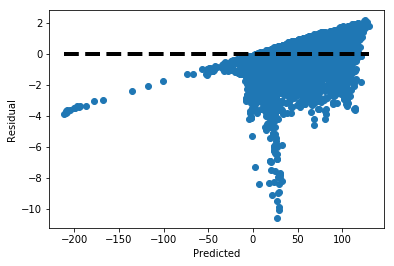

In [80]:
fig, ax = plt.subplots()
residuals = (predicted - y_train)
residuals = stats.zscore(residuals)

ax.scatter(predicted, residuals)
ax.plot([predicted.min(), predicted.max()], [0 for i in [predicted.min(), predicted.max()]] , 'k--', lw=4)
ax.set_xlabel('Predicted')
ax.set_ylabel('Residual')
plt.show()

To improve our model we recreate our datasets this time doing a log base 2 transform on our y values to normalize the data

In [89]:
X_train = df[['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'precipitation', 'Iprec', 'N', 'S', 'E', 'W']]

y_train = np.array([math.log2(x) for x in df.PM_Jingan])
a = df2.No
print(a.shape)
X_test = df2.drop('No', axis=1)
print(X_test.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(9523,)
(9523, 16)
(13164, 16)
(13164,)
(9523, 16)


Our new graph indicates that our transform worked and the distribution of our y values appears much more gaussian in nature

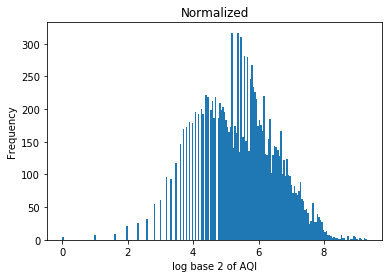

In [90]:
plt.hist(y_train, bins=200)
plt.ylabel('Frequency')
plt.xlabel('log base 2 of AQI');
plt.title('Normalized');

We then feed this into the same model and get an avg mse of roughly 1.5 from our cross validation indicating a much better model. Our measured vs predicted graph shows that we are no longer predicting negative values for aqi and the data is much more evenly distributed. Our residual graph also shows a much more even distribution of our residiuals. However our distribution in our graphs still isn't truly equal and some very high residuals can be seen when values around 20 are predicted.

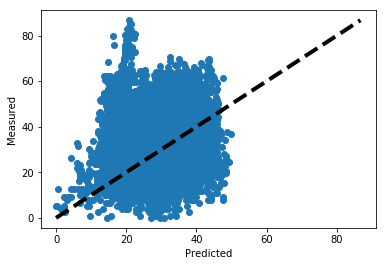

[-1.09742364 -0.61722156 -0.92332561 -1.68505753 -1.55825446 -5.43553191
 -1.988524   -0.72998599 -0.70697492 -0.71640126]
-1.5458700880353806


In [91]:
pipeline = Pipeline([
    ('scaler',sk.preprocessing.StandardScaler()),
    ('clf', LinearRegression())
])
predicted = sk.model_selection.cross_val_predict(pipeline, X_train, y_train, cv=10)

fig, ax = plt.subplots()
predicted = np.array([x**2 for x in predicted])
y_train_unnormed = np.array([ x**2 for x in y_train])
ax.scatter(predicted,y_train_unnormed)
ax.plot([y_train_unnormed.min(), y_train_unnormed.max()], [y_train_unnormed.min(), y_train_unnormed.max()], 'k--', lw=4)
ax.set_xlabel('Predicted')
ax.set_ylabel('Measured')
plt.show()

scores = sk.model_selection.cross_val_score(pipeline,X_train,y_train,cv=10,
    scoring='neg_mean_squared_error')
print(scores)
print(np.mean(scores))

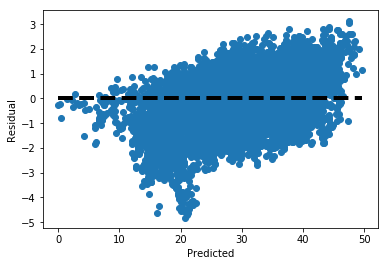

In [92]:
fig, ax = plt.subplots()
residuals = (predicted - y_train_unnormed)
residuals = stats.zscore(residuals)

ax.scatter(predicted, residuals)
ax.plot([predicted.min(), predicted.max()], [0 for i in [predicted.min(), predicted.max()]] , 'k--', lw=4)
ax.set_xlabel('Predicted')
ax.set_ylabel('Residual')
plt.show()

Here we do a quantile plot to see if our residuals are normally distributed indicating that we have made a good model selection. What we want to see here is essentially a line in the format of y=x which indicates that our distrubution of residuals (y) matches that of a normal one (x). As we can see it dosen't quite matchup yet.

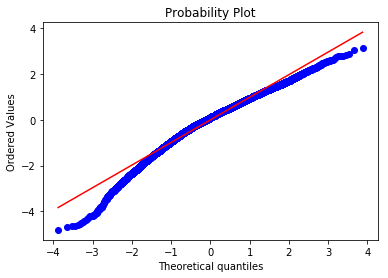

In [93]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

Finally we use the same scaling but change our model to a random forest classifier with 100 n_estimators in order to reduce the variability of our model. As we can see we have a better cross validation mse avg of aprox. 1.1, our residuals are more evenly distributed, and we have reduced our largest residual from aprox. -5 to -4. This is all indicative that this is the best model we have so far.

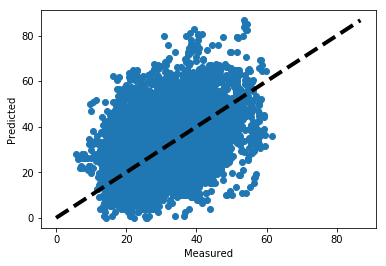

[-1.69512197 -0.54557583 -0.85581169 -1.2550105  -0.97273387 -1.75455141
 -1.65622043 -0.70153232 -0.78847247 -0.9854705 ]
-1.121050098976882


In [85]:
pipeline = Pipeline([
    ('scaler',sk.preprocessing.StandardScaler()),
    ('clf', RandomForestRegressor(n_estimators=100))
])
predicted = sk.model_selection.cross_val_predict(pipeline, X_train, y_train, cv=10)

fig, ax = plt.subplots()
predicted = np.array([x**2 for x in predicted])
y_train_unnormed = np.array([ x**2 for x in y_train])
ax.scatter(predicted,y_train_unnormed)
ax.plot([y_train_unnormed.min(), y_train_unnormed.max()], [y_train_unnormed.min(), y_train_unnormed.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

scores = sk.model_selection.cross_val_score(pipeline,X_train,y_train,cv=10,
    scoring='neg_mean_squared_error')
print(scores)
print(np.mean(scores))

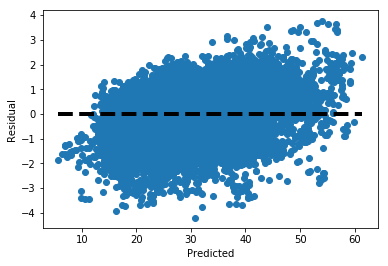

In [86]:
fig, ax = plt.subplots()
residuals = (predicted - y_train_unnormed)
residuals = stats.zscore(residuals)

ax.scatter(predicted, residuals)
ax.plot([predicted.min(), predicted.max()], [0 for i in [predicted.min(), predicted.max()]] , 'k--', lw=4)
ax.set_xlabel('Predicted')
ax.set_ylabel('Residual')
plt.show()

We also do a quartile plot again and we can see a much more linear shape indicating again that random forest regression is in fact a better model for our data.

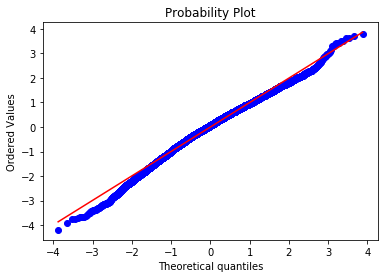

In [87]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

We now train our model and use our test set to make our final predictions for submission to kaggle. Normally I would have a test and a holdout set here but due to the nature of the kaggle competition mse calculations for the test and holdout set were done on kaggle.

In [88]:
pipeline.fit(X_train,y_train)
final = pipeline.predict(X_test)
final = np.array([x**2 for x in final])
print(final)

[18.81651858 26.87769198 19.12966293 ... 44.47649076 44.32252448
 42.9740986 ]
